Event Driven Simulation 

In [2]:
%reset


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson


In [3]:
mapping=pd.read_csv('Data/sinr-tbs-mapping.csv')

In [ ]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

SCHEDULE_T=2 #Clock des Schedulers 

#function to monitor the level of the different queues
def monitor(queue,monitor): 
    monitor.update({env.now: queue.level})
    return monitor

def calculate_tbs(sinr):
    mapping=pd.read_csv('Data/sinr-tbs-mapping.csv')
    tbs=mapping.iloc[sinr].values[1]
    return tbs

#scheduler takes packets from the queues according to the capacity of each user
def scheduler(env, users, SCHEDULE_T):
    
    prb_number=100
    counter=1 #counts the number of scheduling procedures
    alpha=-np.log10(0.01)/100
    
    while True: #größte Warteschlange wird auch bedient
        yield env.timeout(SCHEDULE_T) #for each ms the scheduling is active -> per TTI
        metric=np.array([]) 
        print(env.now)
        users[0].mon= monitor(users[0].queue,users[0].mon)
        users[1].mon= monitor(users[1].queue,users[1].mon)
        users[2].mon= monitor(users[2].queue,users[2].mon)
        
        for i in np.arange(np.size(users)):
                  
            if(users[i].qos==1):
                metric=np.append(metric, (alpha*users[i].queue.level*(users[i].cp/users[i].mR)))  #list the metric of all UEs in the process 
                users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer
                
            elif(users[i].qos==0):
                if(users[i].queue.level>0):
                    metric=np.append(metric,(users[i].cp/users[i].mR))
                    users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer
                if(users[i].queue.level==0):
                    metric=np.append(metric,0)
                    users[i].mR=(1-1/counter)*users[i].mR #Ratenanpassung für alle Nutzer
                    
        
        sched_user_list = (-metric).argsort() # wählt die 5 UEs mit größter Metrik aus #find UE with maximal metric that will be used for scheduling
        
        print(sched_user_list)    
        print(users[2].queue.level)
        remaining_prbs=prb_number
        
        k=0
        while(remaining_prbs>0):
            sched_user=sched_user_list[k]
            
            queue_size=users[sched_user].queue.level
            tbs=users[sched_user].tbs
            print(queue_size/tbs)
            print(type(queue_size/tbs))
            print(remaining_prbs)
            print(type(remaining_prbs))
            
            if((queue_size/tbs)<=remaining_prbs and queue_size>0):
                sched_size=queue_size
                remaining_prbs=remaining_prbs-np.ceil(queue_size/tbs)
                
            elif((queue_size/tbs)>remaining_prbs):
                sched_size=remaining_prbs*tbs
                remaining_prbs=remaining_prbs-sched_size
                k=1
                
            elif(queue_size==0):
                print('empty queue')
                k=1
                break
            else:
                print('something went wrong')
            
            users[sched_user].mR=users[sched_user].mR+(1/counter)*sched_size
            users[sched_user].queue.get(sched_size)
            
        counter=counter+SCHEDULE_T
        
        #print(users[2].mR)
        #print(users[2].cp)
        #print(env.now)

        
            
class ue:
    def __init__(self,sinr,sinr2,cell1,cell2,env,qos):
        self.sinr=sinr
        self.sinr2=sinr2
        self.tbs=calculate_tbs(sinr)
        self.tbs2=calculate_tbs(sinr2)
        self.qos=qos
        self.cp=0.5*0.7*20000000*np.log2(1+np.power(10,sinr/10))/8000 #division by 8000 to determine number of bits that can be transmitted per TTI (1ms)
        self.cp2=0.5*0.7*20000000*np.log2(1+np.power(10,sinr2/10))/8000
        self.cell1=cell1
        self.cell2=cell2
        self.mR=0.1 #mittlere Rate
        self.queue=simpy.Container(env)
        self.mon={}
        self.metric=self.sinr+self.queue.level
        
    def rt_user(self,env):
        on_off=1
        counter=0
        while True:
            if(on_off==1 and counter<3000):
                self.queue.put(160) #20 bytes
                mon= monitor(self.queue,self.mon)
                #yield env.timeout(poisson.rvs(6, 1))
                #print('On Phase')
                #print(self.queue.level)
                counter=counter+20
                #print(counter)
                yield env.timeout(20) #every 20ms new packet
            elif(on_off==0):
                on_off=1
                #print('Off Phase')
                #print(self.queue.level)
                yield env.timeout(3000) #3s no packet to be sent
            elif(on_off==1 and counter>=3000):
                on_off=0
                counter=0
                #print('change from ON-OFF')
            
    def user_packets(self,env):
        while True:
            print('normal ue')
            #print('o-user')
            self.queue.put(2000)
            #self.mon= monitor(self.queue,self.mon)
            yield env.timeout(poisson.rvs(500, 1))
    

##Ausführung der Simulation

env=simpy.Environment()
#env = simpy.rt.RealtimeEnvironment(factor=1/10)

ue_list=np.array([])
#ue_list=np.append(ue_list,ue(15,5,'19','18',env,0))
#ue_list=np.append(ue_list,ue(15,5,'19','18',env,0))
#ue_list=np.append(ue_list,ue(20,7,'19','18',env,0))


for i in np.arange(0,100):
    ue_list=np.append(ue_list,ue(15,7,'19','18',env,0))


env.process(scheduler(env,ue_list,SCHEDULE_T))

#env.process(ue_list[0].rt_user(env))
#env.process(ue_list[1].user_packets(env))
#env.process(ue_list[2].user_packets(env))

for i in np.arange(0,100):
    env.process(ue_list[i].user_packets(env))


env.run(until=5000)

normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue
normal ue


<ipython-input-64-61bcfa5deb7a>:43: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,(users[i].cp/users[i].mR))


88.0
<class 'numpy.float64'>
empty queue
186
[ 8  2  3  4  5  6  7 13 68 69 70  0 72 73 67 74 71 66 61 64 63 62 75 60
 59 58 57 56 65 76 80 78 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82
 81 55 79 77 54 49 52 27 26 25 24 23 22 21 20 19 18 17 16 15 14 12 11 10
  9  1 28 29 30 31 51 50 98 48 47 46 45 44 43 53 42 40 39 38 37 36 35 34
 33 32 41 99]
2000
11.11111111111111
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
88.0
<class 'numpy.float64'>
empty queue
188
[ 2  3  4  5  6  7 13  0 67 68 69 72 71 66 73 70 65 61 63 62 74 60 59 58
 57 56 55 64 75 79 77 97 96 95 94 93 92 91 90 89 76 88 86 85 84 83 82 81
 80 54 78 87 53 49 51 26 25 24 23 22 21 20 19 18 17 16 15 14 12 11 10  9
  8  1 27 28 29 30 50 98 48 47 46 45 44 43 42 52 41 39 38 37 36 35 34 33
 32 31 40 99]
2000
11.11111111111111
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
88.0
<class 'numpy.float64'>
empty queue
190
[13  3  4  5  6  7 73 72 71 70 69 68 67 66 65 64  0 62 74 61 60 59 

 27 26 36 99]
0
0.0
<class 'numpy.float64'>
100
<class 'int'>
empty queue
416
[ 0 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 73 51
 74 76 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 75
 50 49 48 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1
 22 23 24 25 47 46 45 44 43 42 41 40 39 38 98 37 35 34 33 32 31 30 29 28
 27 26 36 99]
0
0.0
<class 'numpy.float64'>
100
<class 'int'>
empty queue
418
[ 0 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 73 51
 74 76 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 75
 50 49 48 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1
 22 23 24 25 47 46 45 44 43 42 41 40 39 38 98 37 35 34 33 32 31 30 29 28
 27 26 36 99]
0
0.0
<class 'numpy.float64'>
100
<class 'int'>
empty queue
420
[ 0 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 73 51
 74 76 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 75
 50 49 48 21 20 19 18 17 16 15 14 13

 64 65 33 99]
0
11.11111111111111
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
88.0
<class 'numpy.float64'>
empty queue
584
[31 80 81 40 82 34 83 35 84 36 85 37 86 38 87 39 88 89 44 41 90 42 91 43
 92 93 46 94 95 47 96 97 48 49  0 32 69 70 71 72 73 74 75 76 77 78 79 18
 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1 68 33 67 65 30 29 28
 27 26 25 24 23 22 45 21 20 19 98 50 51 52 53 54 55 56 57 58 59 60 61 62
 63 64 66 99]
0
11.11111111111111
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
88.0
<class 'numpy.float64'>
empty queue
586
[80 81 40 82 34 83 35 84 36 85 37 86 38 87 39 88 89 44 41 90 42 91 43 92
 93 46 94 95 47 96 97 48 49  0 32 69 70 71 72 73 74 75 76 77 78 79 18 17
 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1 68 67 66 65 31 30 29 28
 27 26 25 24 23 22 45 21 20 19 33 98 51 52 53 54 55 56 57 58 59 60 61 62
 63 64 50 99]
0
11.11111111111111
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
88.0
<class 'n

[ 0 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 73 51
 74 76 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 75
 50 49 48 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1
 22 23 24 25 47 46 45 44 43 42 41 40 39 38 98 37 35 34 33 32 31 30 29 28
 27 26 36 99]
0
0.0
<class 'numpy.float64'>
100
<class 'int'>
empty queue
774
[ 0 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 73 51
 74 76 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 75
 50 49 48 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1
 22 23 24 25 47 46 45 44 43 42 41 40 39 38 98 37 35 34 33 32 31 30 29 28
 27 26 36 99]
0
0.0
<class 'numpy.float64'>
100
<class 'int'>
empty queue
776
[ 0 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 73 51
 74 76 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 75
 50 49 48 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1
 22 23 24 25 47 46 45 44 43 42 41 40 39 3

[11 12 61 73 77 76 29 30 39 96 49 60 54 55 56 71 70 69 62 68 66 65 64 57
 58 59 67 63 75 74 97 95 94 93 92 91 90 89 88 72 87 85 84 83 82 81 80 79
 78 53 86 52  0 50 22 21 20 19 18 17 16 15 14 23 13  9  8  7  6  5  4  3
  2  1 10 51 24 26 98 48 47 46 45 44 43 42 41 25 40 37 36 35 34 33 32 31
 28 27 38 99]
0
11.11111111111111
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
88.0
<class 'numpy.float64'>
empty queue
normal ue
978
[12 61 73 77 76 29 30 36 39 96 49 63 54 55 56 57 70 69 62 68 66 58 65 64
 59 60 67 71 74 53 97 95 94 93 92 91 90 89 88 72 87 85 84 83 82 81 80 79
 78 75 86 52  0 50 21 20 19 18 17 16 15 14 13 22 11  9  8  7  6  5  4  3
  2  1 10 51 23 25 98 48 47 46 45 44 43 42 41 24 40 37 35 34 33 32 31 28
 27 26 38 99]
0
11.11111111111111
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
88.0
<class 'numpy.float64'>
empty queue
normal ue
normal ue
980
[ 8 61 73 77 76 29 30 36 39 90 96 49 62 59 58 64 65 57 66 67 68 69 56 55
 70 54 60 63 74

 30 29  3 99]
0
11.11111111111111
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
88.0
<class 'numpy.float64'>
empty queue
1144
[48 49  0  3 72 71 70 69 68 67 66 65 64 73 63 61 60 59 58 57 56 55 54 53
 62 74 75 76 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78
 77 52  2 51 98 23 22 21 20 19 18 17 16 15 24 14 12 11 10  9  8  7  6  5
  4 13 25 26 27  1 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30
 29 28 50 99]
0
11.11111111111111
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
88.0
<class 'numpy.float64'>
empty queue
1146
[49  0  2 72 71 70 69 68 67 66 65 64 73 63 61 60 59 58 57 56 55 54 53 62
 74 75 76 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77
 52 51 50 98 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4
  3 24  1 25 27 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30
 29 28 26 99]
0
11.11111111111111
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
88.0
<class 

 27 26 36 99]
0
0.0
<class 'numpy.float64'>
100
<class 'int'>
empty queue
1348
[ 0 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 73 51
 74 76 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 75
 50 49 48 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1
 22 23 24 25 47 46 45 44 43 42 41 40 39 38 98 37 35 34 33 32 31 30 29 28
 27 26 36 99]
0
0.0
<class 'numpy.float64'>
100
<class 'int'>
empty queue
1350
[ 0 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 73 51
 74 76 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 75
 50 49 48 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1
 22 23 24 25 47 46 45 44 43 42 41 40 39 38 98 37 35 34 33 32 31 30 29 28
 27 26 36 99]
0
0.0
<class 'numpy.float64'>
100
<class 'int'>
empty queue
1352
[ 0 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 73 51
 74 76 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 75
 50 49 48 21 20 19 18 17 16 15 14

 24 23 55 99]
0
11.11111111111111
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
88.0
<class 'numpy.float64'>
empty queue
normal ue
normal ue
1532
[32 26 75 74 78 79 31 80 81 82 34 33 83 84 85 87 39 88 89 41 90 42 91 43
 46 45 47 96 48 49 62 61 60 59 58 64 63 65 72 67 97 95 94 93 92 86 66 77
 73 57 71 70 69 68 76 56  0 54 18 17 16 15 14 13 12 11 19 10  8  7  6  5
  4  3  2  1  9 55 20 22 53 52 51 50 98 44 40 38 21 37 35 30 29 28 27 25
 24 23 36 99]
0
11.11111111111111
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
88.0
<class 'numpy.float64'>
empty queue
1534
[26 75 74 78 79 31 80 81 82 34 33 83 84 85 87 39 88 89 41 90 42 91 43 46
 45 47 96 48 49 64 63 61 60 59 58 62 65 72 67 97 95 94 93 92 86 66 77 73
 57 71 70 69 68 76 56  0 54 18 17 16 15 14 13 12 11 19 10  8  7  6  5  4
  3  2  1  9 20 21 22 53 52 51 50 98 44 40 38 37 36 35 32 30 29 28 27 25
 24 23 55 99]
0
11.11111111111111
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.fl

 27 26 36 99]
0
0.0
<class 'numpy.float64'>
100
<class 'int'>
empty queue
1726
[ 0 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 73 51
 74 76 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 75
 50 49 48 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1
 22 23 24 25 47 46 45 44 43 42 41 40 39 38 98 37 35 34 33 32 31 30 29 28
 27 26 36 99]
0
0.0
<class 'numpy.float64'>
100
<class 'int'>
empty queue
1728
[ 0 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 73 51
 74 76 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 75
 50 49 48 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1
 22 23 24 25 47 46 45 44 43 42 41 40 39 38 98 37 35 34 33 32 31 30 29 28
 27 26 36 99]
0
0.0
<class 'numpy.float64'>
100
<class 'int'>
empty queue
1730
[ 0 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 73 51
 74 76 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 75
 50 49 48 21 20 19 18 17 16 15 14

 27 26 36 99]
0
11.11111111111111
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
88.0
<class 'numpy.float64'>
empty queue
normal ue
1942
[51 49 53 72 71 70 69 68 67 66 65 64 63 73 61 60 59 58 57 56 55 54 52 62
 74 76 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 75
 50  0 48 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1
 22 23 24 25 47 46 45 44 43 42 41 40 39 38 98 37 35 34 33 32 31 30 29 28
 27 26 36 99]
0
11.11111111111111
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
88.0
<class 'numpy.float64'>
empty queue
1944
[49 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 73 51
 74 76 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 75
 50  0 48 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1
 22 23 24 25 47 46 45 44 43 42 41 40 39 38 98 37 35 34 33 32 31 30 29 28
 27 26 36 99]
0
11.11111111111111
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
88

 32 31 40 49]
0
11.11111111111111
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
88.0
<class 'numpy.float64'>
empty queue
2112
[95 47 96 48 99  0  6 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57
 56 55 74 75 76 77 97  1  2 94 93 92 91 90 89 54 88 86 85 84 83 82 81 80
 79 78 87 53 52 51 26 25 24 23 22 21 20 19 18 27 17 15 14 13 12 11 10  9
  8  7 16  5 28 30 50 98  3  4 46 45 44 43 42 29 41 39 38 37 36 35 34 33
 32 31 40 49]
0
11.11111111111111
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
88.0
<class 'numpy.float64'>
empty queue
2114
[47 96 48 99  0  5 73 72 71 70 69 68 67 66 65 74 64 62 61 60 59 58 57 56
 55 54 63 53 75 77 97  1 95 94 93 92 91 90 89 76 88 86 85 84 83 82 81 80
 79 78 87  4 52 50 25 24 23 22 21 20 19 18 17 26 16 14 13 12 11 10  9  8
  7  6 15 51 27 29 98  2  3 46 45 44 43 42 41 28 40 38 37 36 35 34 33 32
 31 30 39 49]
0
11.11111111111111
<class 'numpy.float64'>
100
<class 'int'>
0.0
<class 'numpy.float64'>
88.0
<class 

In [20]:
prb_number=100

In [ ]:
 if((queue_size/tbs)<=float(prb_number))

In [50]:
np.ceil(1.2)

2.0

(array([205.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  95.]),
 array([14.61092218, 14.62852571, 14.64612923, 14.66373275, 14.68133627,
        14.69893979, 14.71654331, 14.73414683, 14.75175035, 14.76935387,
        14.78695739]),
 <BarContainer object of 10 artists>)

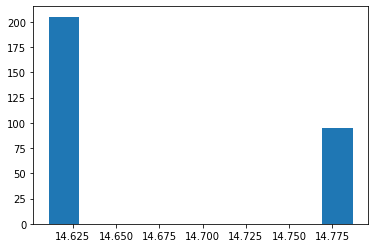

In [57]:
a=np.zeros(300)
for i in np.arange(0,300):
    a[i]=ue_list[i].mR
    
plt.hist(a)

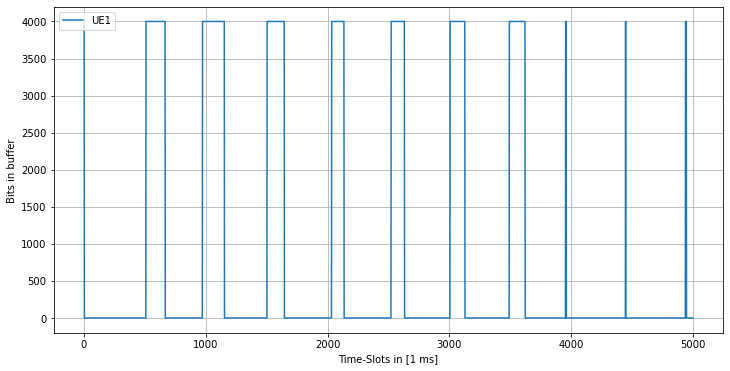

In [62]:
plt.figure(figsize=(12,6))
plt.plot(ue_list[0].mon.keys(),ue_list[0].mon.values(),label='UE1')
#plt.plot(ue_list[1].mon.keys(),ue_list[1].mon.values(),label='UE2')
#plt.plot(ue_list[2].mon.keys(),ue_list[2].mon.values(),label='UE3')
plt.xlabel('Time-Slots in [1 ms]')
plt.ylabel('Bits in buffer')
plt.legend(loc="upper left")
plt.grid()
#plt.axvline(x = 13, color = 'b', label = 'axvline - full height')
#plt.axvline(x = 27, color = 'b', label = 'axvline - full height')

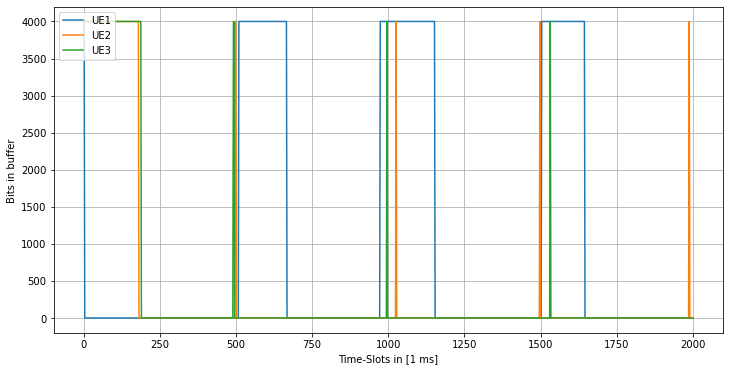

In [63]:
plt.figure(figsize=(12,6))
plt.plot(list(ue_list[0].mon.keys())[:1000],list(ue_list[0].mon.values())[:1000],label='UE1')
plt.plot(list(ue_list[1].mon.keys())[:1000],list(ue_list[1].mon.values())[:1000],label='UE2')
plt.plot(list(ue_list[2].mon.keys())[:1000],list(ue_list[2].mon.values())[:1000],label='UE3')
plt.xlabel('Time-Slots in [1 ms]')
plt.ylabel('Bits in buffer')
plt.legend(loc="upper left")
plt.grid()
#plt.axvline(x = 13, color = 'b', label = 'axvline - full height')
#plt.axvline(x = 27, color = 'b', label = 'axvline - full height')